   Year  Employed  Unemployed  With health insurance coverage  \
0  2013    275356       34431                          545710   
1  2014    270867       36307                          560510   
2  2015    270992       30358                          566583   
3  2016    283328       27759                          564825   
4  2017    284018       23261                          561648   

   No health insurance coverage  \
0                         65526   
1                         51894   
2                         46340   
3                         41003   
4                         41933   

   Households - Households receiving food stamps/SNAP  Below poverty level  \
0                                              63230                 54193   
1                                              61860                 53274   
2                                              61876                 50232   
3                                              61673                 50341   
4       

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



LSTM Models Built.
Urban Model Input Shape: (None, 3, 7)
Suburban Model Input Shape: (None, 3, 7)
Rural Model Input Shape: (None, 3, 7)

Training Baltimore City Model...

Training Prince George's County Model...

Training Calvert County Model...

Models Trained.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step

Evaluation for Baltimore City:
  MAE: 0.2179
  RMSE: 0.2179


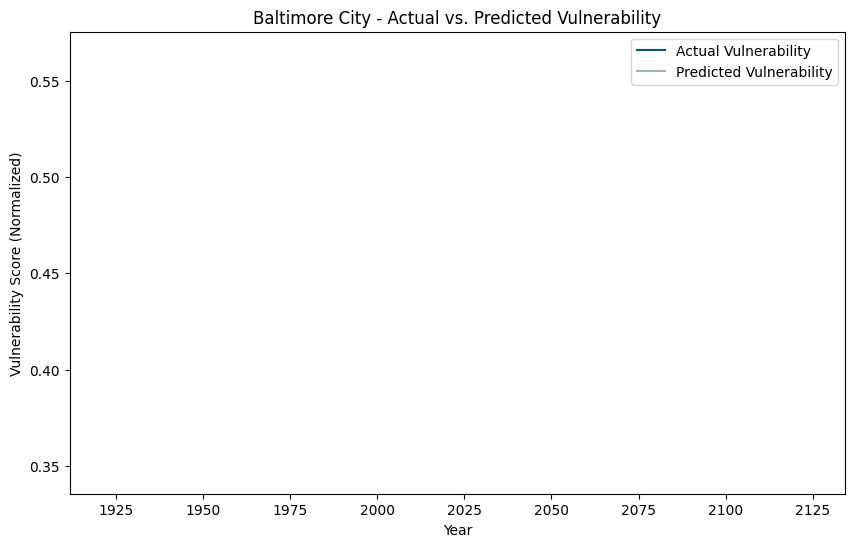

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step

Evaluation for Prince George's County:
  MAE: 0.1016
  RMSE: 0.1016


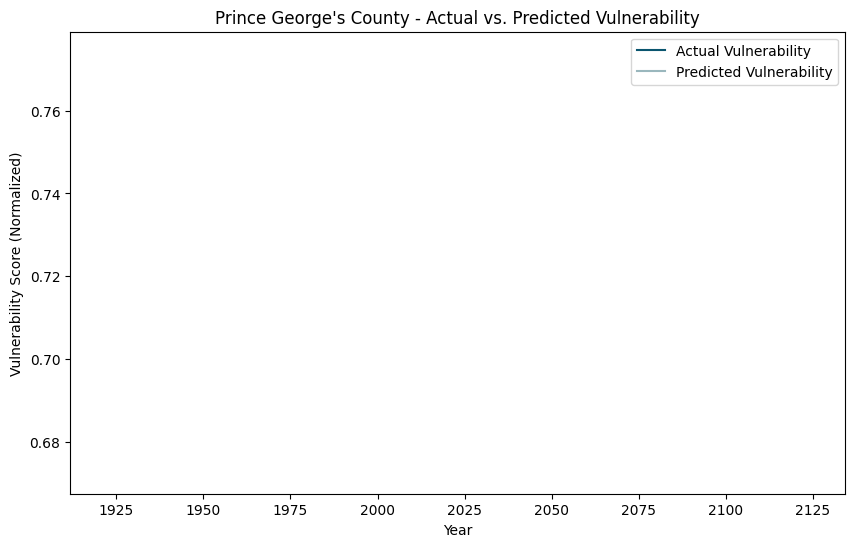

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step

Evaluation for Calvert County:
  MAE: 0.0631
  RMSE: 0.0631


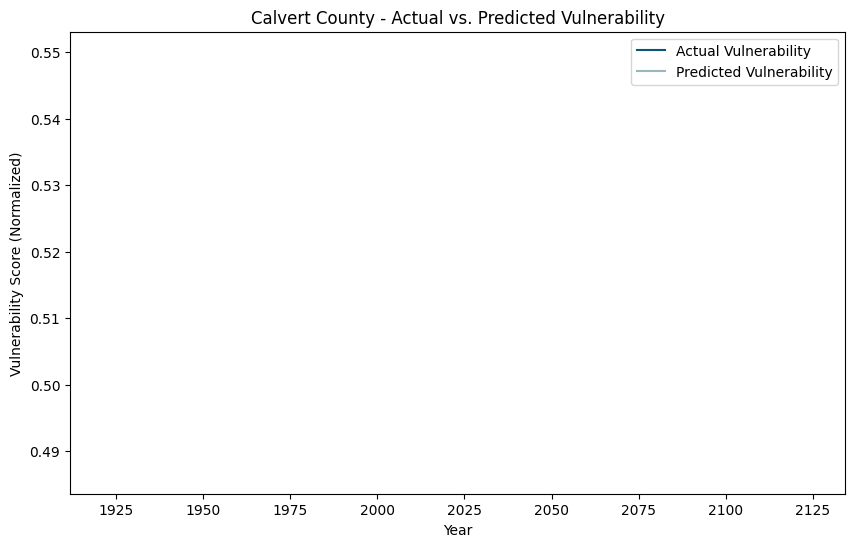


--- Fairness Analysis ---

Fairness Analysis for Baltimore City (Original Columns):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
  Subgroup: Unemployed
    MAE (vs. Predicted): 0.5644
    RMSE (vs. Predicted): 0.5644
  Subgroup: No health insurance coverage
    MAE (vs. Predicted): 0.5459
    RMSE (vs. Predicted): 0.5459
  Subgroup: Households - Households receiving food stamps/SNAP
    MAE (vs. Predicted): 0.2619
    RMSE (vs. Predicted): 0.2619
  Subgroup: Below poverty level
    MAE (vs. Predicted): 0.3425
    RMSE (vs. Predicted): 0.3425
  Subgroup: With a disability
    MAE (vs. Predicted): 0.3669
    RMSE (vs. Predicted): 0.3669
  Subgroup: Age 65+
    MAE (vs. Predicted): 0.4356
    RMSE (vs. Predicted): 0.4356
  Subgroup: Total Population
    MAE (vs. Predicted): 0.5644
    RMSE (vs. Predicted): 0.5644

Fairness Analysis for Prince George's County (Original Columns):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
  Subgroup: Unemployed
    MAE (vs. Predicted): 0.7367
    RMSE (vs. Predicted)

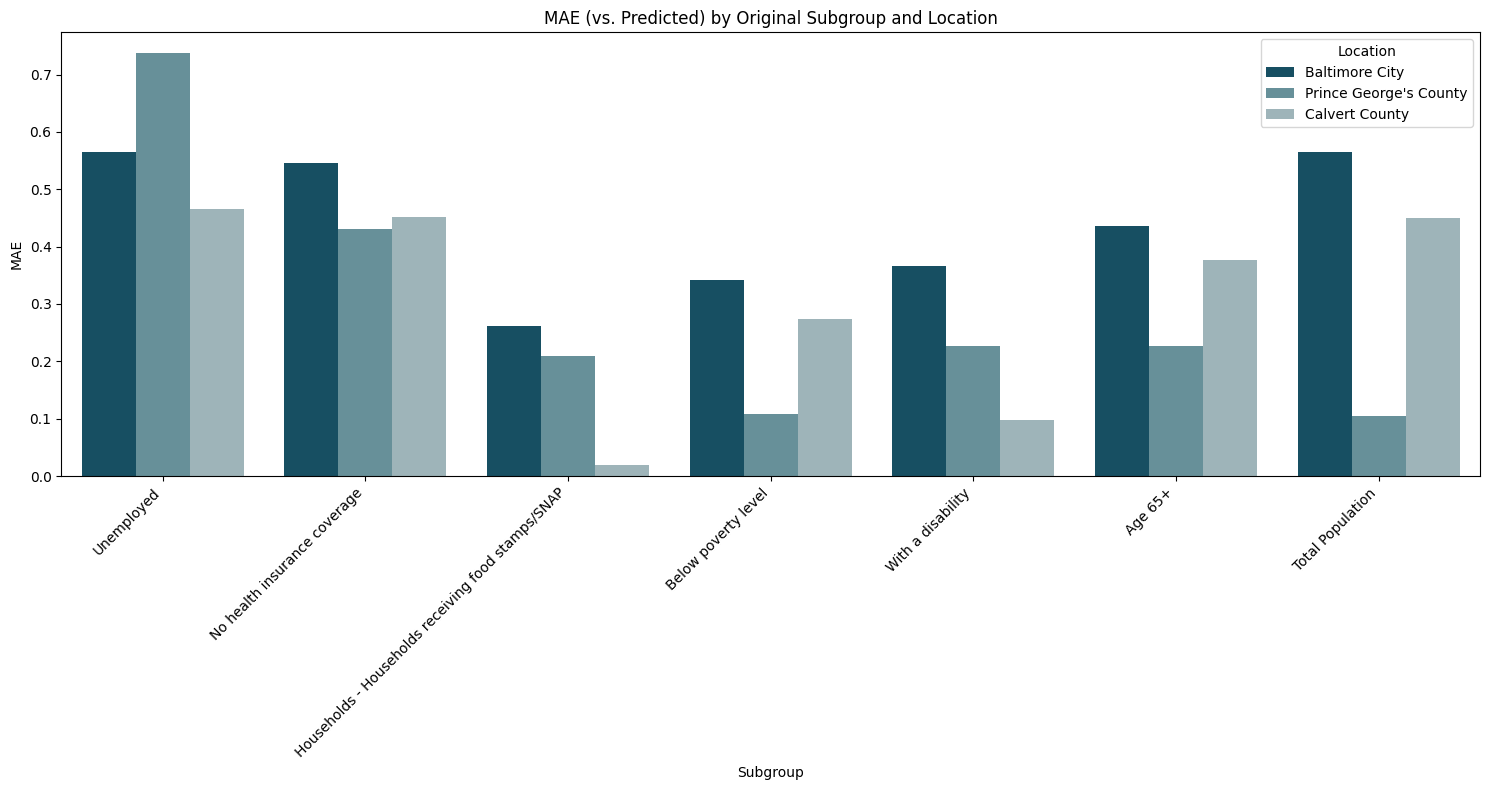

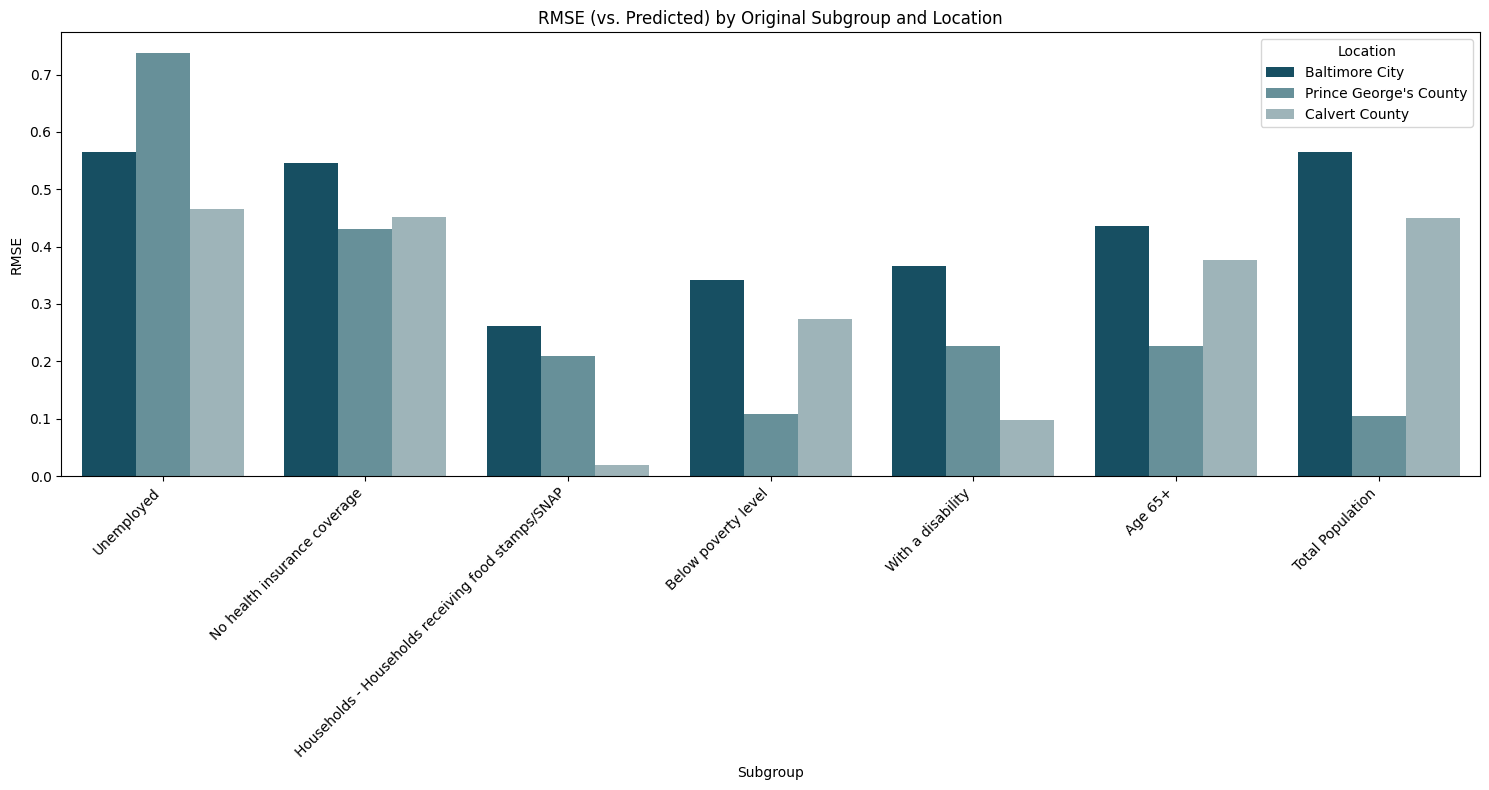

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# --- Part 1: Data Acquisition and Preprocessing ---
urban_df = pd.read_csv("Data Sets - Baltimore City.csv")
urban_df['area_type'] = 'Baltimore City'

suburban_df = pd.read_csv("Data Sets - Prince George\'s County.csv")
suburban_df['area_type'] = 'Prince George\'s County'

rural_df = pd.read_csv("Data Sets - Calvert County.csv")
rural_df['area_type'] = 'Calvert County'

print(urban_df.head())

# --- Step 3: Create Simplified Social Vulnerability Score ---
from sklearn.preprocessing import MinMaxScaler

def create_vulnerability_score(df, indicators):
    df_subset = df[indicators].copy()
    scaler = MinMaxScaler()
    df[indicators] = scaler.fit_transform(df_subset)
    df['vulnerability_score'] = df[indicators].mean(axis=1)
    return df

# Define the columns you want to use for the vulnerability score
vulnerability_indicators = ['Unemployed', 'No health insurance coverage',
                            'Households - Households receiving food stamps/SNAP',
                            'Below poverty level', 'With a disability', 'Age 65+',
                            'Total Population']

urban_df = create_vulnerability_score(urban_df.copy(), vulnerability_indicators)
suburban_df = create_vulnerability_score(suburban_df.copy(), vulnerability_indicators)
rural_df = create_vulnerability_score(rural_df.copy(), vulnerability_indicators)

print("\nVulnerability Scores Calculated.")
print(urban_df[['area_type', 'vulnerability_score']].head())
print(suburban_df[['area_type', 'vulnerability_score']].head())
print(rural_df[['area_type', 'vulnerability_score']].head())

# --- Prepare data for LSTM ---
def prepare_lstm_data(df, n_steps, feature_cols, target_col='vulnerability_score'):
    X, y = [], []
    for i in range(len(df) - n_steps):
        X.append(df[feature_cols].iloc[i:(i + n_steps)].values)
        y.append(df[target_col].iloc[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 3 # Using 3 time steps as before

urban_X, urban_y = prepare_lstm_data(urban_df, n_steps, vulnerability_indicators)
suburban_X, suburban_y = prepare_lstm_data(suburban_df, n_steps, vulnerability_indicators)
rural_X, rural_y = prepare_lstm_data(rural_df, n_steps, vulnerability_indicators)

# --- Split data into training and testing sets (6 years train, rest test) ---
def split_data(X, y, train_years=6):
    num_samples = len(X)
    train_size = train_years  # Assuming each row represents one year
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    return X_train, X_test, y_train, y_test

urban_X_train, urban_X_test, urban_y_train, urban_y_test = split_data(urban_X, urban_y, train_years=6)
suburban_X_train, suburban_X_test, suburban_y_train, suburban_y_test = split_data(suburban_X, suburban_y, train_years=6)
rural_X_train, rural_X_test, rural_y_train, rural_y_test = split_data(rural_X, rural_y, train_years=6)

print("\nData Prepared and Split for LSTM (6 years training).")
print("Urban Train Shape:", urban_X_train.shape, urban_y_train.shape)
print("Urban Test Shape:", urban_X_test.shape, urban_y_test.shape)
print("Suburban Train Shape:", suburban_X_train.shape, suburban_y_train.shape)
print("Suburban Test Shape:", suburban_X_test.shape, suburban_y_test.shape)
print("Rural Train Shape:", rural_X_train.shape, rural_y_train.shape)
print("Rural Test Shape:", rural_X_test.shape, rural_y_test.shape)

# --- Part 2: LSTM Model Development (Location-Specific) ---
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Get the number of features and timesteps for the LSTM input shape
n_features_urban = urban_X_train.shape[2]
n_features_suburban = suburban_X_train.shape[2]
n_features_rural = rural_X_train.shape[2]
n_timesteps = urban_X_train.shape[1] # Assuming same timesteps for all

urban_model = build_lstm_model((n_timesteps, n_features_urban))
suburban_model = build_lstm_model((n_timesteps, n_features_suburban))
rural_model = build_lstm_model((n_timesteps, n_features_rural))

print("\nLSTM Models Built.")
print("Urban Model Input Shape:", urban_model.input_shape)
print("Suburban Model Input Shape:", suburban_model.input_shape)
print("Rural Model Input Shape:", rural_model.input_shape)

# --- Part 3: Model Training (Location-Specific) ---
epochs = 50
batch_size = 1 # Changed batch size to 1 because of limited data points

print("\nTraining Baltimore City Model...")
urban_history = urban_model.fit(urban_X_train, urban_y_train, epochs=epochs, batch_size=batch_size, verbose=0)

print("\nTraining Prince George's County Model...")
suburban_history = suburban_model.fit(suburban_X_train, suburban_y_train, epochs=epochs, batch_size=batch_size, verbose=0)

print("\nTraining Calvert County Model...")
rural_history = rural_model.fit(rural_X_train, rural_y_train, epochs=epochs, batch_size=batch_size, verbose=0)

print("\nModels Trained.")

# --- Part 4: Model Evaluation (Location-Specific) ---
def evaluate_model(model, X_test, y_test, original_df, location_name):
    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    print(f"\nEvaluation for {location_name}:")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")

    # Visualization
    plt.figure(figsize=(10, 6))

    # Get the years corresponding to the test set
    num_test_samples = len(y_test)
    test_years = original_df['Year'].iloc[-num_test_samples:].values

    # Define the colors
    actual_color = "#0a556f"
    predicted_color = "#9ab7bd"

    plt.plot(test_years, y_test, label='Actual Vulnerability', color=actual_color)
    plt.plot(test_years, predictions, label='Predicted Vulnerability', color=predicted_color)
    plt.title(f'{location_name} - Actual vs. Predicted Vulnerability')
    plt.xlabel('Year')
    plt.ylabel('Vulnerability Score (Normalized)')
    plt.legend()
    plt.show()

    return predictions, y_test

urban_predictions, urban_y_actual = evaluate_model(urban_model, urban_X_test, urban_y_test, urban_df, 'Baltimore City')
suburban_predictions, suburban_y_actual = evaluate_model(suburban_model, suburban_X_test, suburban_y_test, suburban_df, 'Prince George\'s County')
rural_predictions, rural_y_actual = evaluate_model(rural_model, rural_X_test, rural_y_test, rural_df, 'Calvert County')

# --- Part 5: Fairness Analysis (Location-Specific) ---
def fairness_analysis_original_cols(model, X_test, y_test, original_df, location_name, subgroup_cols):
    print(f"\nFairness Analysis for {location_name} (Original Columns):")
    results = {}
    predictions = model.predict(X_test)

    test_years = original_df['Year'].iloc[-len(y_test):].values
    predictions_df = pd.DataFrame({'Year': test_years.flatten(), 'predicted_vulnerability': predictions.flatten()})
    original_test_df = original_df.iloc[-len(y_test):].reset_index(drop=True)
    combined_df = pd.concat([original_test_df, predictions_df.drop(columns=['Year'])], axis=1)

    for subgroup_col in subgroup_cols:
        if subgroup_col in combined_df.columns:
            mae = mean_absolute_error(combined_df[subgroup_col], combined_df['predicted_vulnerability'])
            rmse = np.sqrt(mean_squared_error(combined_df[subgroup_col], combined_df['predicted_vulnerability']))
            print(f"  Subgroup: {subgroup_col}")
            print(f"    MAE (vs. Predicted): {mae:.4f}")
            print(f"    RMSE (vs. Predicted): {rmse:.4f}")
            results[subgroup_col] = {'MAE': mae, 'RMSE': rmse}
        else:
            print(f"  Warning: Subgroup column '{subgroup_col}' not found in DataFrame for {location_name}.")
            results[subgroup_col] = {'MAE': None, 'RMSE': None}
    return results

print("\n--- Fairness Analysis ---")

urban_fairness_results_original = fairness_analysis_original_cols(urban_model, urban_X_test, urban_y_test, urban_df, 'Baltimore City', vulnerability_indicators)
suburban_fairness_results_original = fairness_analysis_original_cols(suburban_model, suburban_X_test, suburban_y_test, suburban_df, 'Prince George\'s County', vulnerability_indicators)
rural_fairness_results_original = fairness_analysis_original_cols(rural_model, rural_X_test, rural_y_test, rural_df, 'Calvert County', vulnerability_indicators)

# @title


# --- Part 6: Comparative Fairness Analysis (Across Locations - Original Columns) ---
print("\nComparative Fairness Analysis (Across Locations - Original Columns):")

for subgroup_col in vulnerability_indicators:
    print(f"\nSubgroup: {subgroup_col}")
    for location, results in zip(['Baltimore City', 'Prince George\'s County', 'Calvert County'],
                                 [urban_fairness_results_original, suburban_fairness_results_original, rural_fairness_results_original]):
        if subgroup_col in results and results[subgroup_col]['MAE'] is not None:
            print(f"  {location}: MAE (vs. Predicted) = {results[subgroup_col]['MAE']:.4f}, RMSE (vs. Predicted) = {results[subgroup_col]['RMSE']:.4f}")
        else:
            print(f"  {location}: No data for this subgroup.")

# --- Part 7: Visualization (Comparative - Original Columns) ---
data_original = []
for location, results in zip(['Baltimore City', 'Prince George\'s County', 'Calvert County'],
                             [urban_fairness_results_original, suburban_fairness_results_original, rural_fairness_results_original]):
    for subgroup, metrics in results.items():
        if metrics['MAE'] is not None:
            data_original.append({'Location': location, 'Subgroup': subgroup, 'MAE': metrics['MAE'], 'RMSE': metrics['RMSE']})

vis_df_original = pd.DataFrame(data_original)

# Define the colors
colors = ["#0a556f", "#5f95a1", "#9ab7bd"]

plt.figure(figsize=(15, 8))
sns.barplot(x='Subgroup', y='MAE', hue='Location', data=vis_df_original, palette=colors)
plt.title('MAE (vs. Predicted) by Original Subgroup and Location')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
sns.barplot(x='Subgroup', y='RMSE', hue='Location', data=vis_df_original, palette=colors)
plt.title('RMSE (vs. Predicted) by Original Subgroup and Location')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()